# 1. 深度学习基础网络手动搭建与快速实现

## 1.1 导言

通过此前几节课的学习，我们基本掌握了几种神经网络的核心原理和实践方法，也就是线性回归、逻辑回归和softmax回归的基本原理和PyTorch中调库实现的方法。同时，我们也了解了神经网络模型的诸多基本概念和神经网络模型构成的基本结构（点线结构）,而对于神经网络来说，再复杂的模型都是由这些基础模型构成的，再复杂的模型其基本原理也是和基础模型相同的。

然而，再这个过程中我们发现，尽管深度学习也属于机器学习范畴，基本的建模理念和机器学习类似，比如说需要确定目标函数和损失函数，找到合适的优化算法对参数进行求解等等。但实际落地的操作层面，也就是利用PyTorch再进行建模的过程却和经典机器学习有很大的差别，或者说和最大的机器学习库Scikit-learn中定义的机器学习建模方法有较大的差别。比如说，在数据读取过程中，PyTorch需要将数据先封装在一个Dataset的子类里面，然后利用DataLoader进行装载，然后才能带入训练，而sklearn则可以直接读取Pandas中存储的面板数据建模；再比如再模型调用的过程，PyTorch需要先创建一个Module的子类去定义模型基本结构，然后才能实例化这个模型去训练，并且训练过程中优化算法也是某个类的实例化结果，再训练过程中需要使用这个类的诸多方法来将梯度清零或者更新神经网络之间连接的权重，相比之下SKlearn则简单的多，只需要再实例化模型的过程中定义好超参数的取值，然后使用fit 方法进行训练即可。那为何PyTorch的整个实现过程会更加复杂？归根结底，还是和深度学习建模的特殊性有关。

类似PyTorch的这种，看似对初学者略显复杂的建模流程，实际上都是为了能够更好的满足深度学习建模的一般情况：针对非结构化数据，在超大规模的数据集上进行模型训练。我们前面提到PyTorch在读取数据的过程中需要使用Dataset和DataLoader数据进行封装和加载，其实是为了能够实现数据的迭代式存储和映射式存储，也就是通过生成数据的生成器或者保存数据的映射关系，来避免数据的重复存储，如进行小批量数据数据划分时，PyTorch并未真正意义上的将数据进行切分然后单独存储，二十创建了每个“小批”数据和原数据的映射关系（或者说“小批数据”的索引值），然后借助这种映射关系，在实际需要使用这些数据的时候再对其进行提取。这么做的原因，当然是因为进行海量数据处理是，划分多个数据集引进额外的内存空间是显然不合适的。当然PyTorch再设计的时候将很多数据预处理的方法也放到了数据封装和加载的流程中，这些我们将在后面谈到。而PyTorch的建模过程中，类的频繁使用其实也是为了能够更加灵活的创建不同类型的神经网络。

但不管怎么样，这样的一个建模流程还是给初学者造成一定的学习难度，然而熟练掌握深度学习建模流程，熟练使用基本函数和类却是后续学习的基础，因此，在正式进入到下一个阶段之前，也就是进入深度学习的优化算法之前，我们需要进行一段时间的强化学习，通过对此前的基础神经网络进行手动建模和调库的实现，强化代码能力。

此外，在此前几节课的学习当中我们也发现，PyTorch作为新兴的深度学习计算框架，在某些功能上还显得不够晚上，比如我们此前看到的将“概率”结果划为类别判别的过程，准确率计算过程等等，PyTorch中都没有原生函数作为支持，因此我们需要手动编写此类函数。外加模型训练过程本身也可以封装在函数内，因此本节我们也将手动编写PyTorch实际应用中的实用函数作为nn.functional的补充。

另外，为了在后续的优化算法部分课程中更好的观察模型不同算法能够起到的作用，本节课程还将介绍数据集创建函数、模型可视化工具TensorBoard安装和实用方法；同时虽然是建模练习，但可能会涉及一定规模的运算，因此本节课还将介绍模型的GPU运行方法。

## 1.2 深度学习建模实验中数据集生成函数的创建与使用

为了方便后续练习的展开，我们尝试自己创建一个生成器，用于自主生成一些符合某些条件，具备某些特性的数据集。相比于传统的机器学习领域，深度学习的数据集往往更加复杂，大多数情况无法把数据集生成数据表来进行查看，在建模过程中，往往都是设计完模型结构后直接训练模型，只能通过一些指标来观察模型的效果，外加复杂神经网络内部其实是“黑箱”，因此我们基本只能控制流程，输入数据，观测结果，说是炼丹师也并不为过。不过在学习阶段，尤其是在学习优化算法的过程中，我们还是希望能够从更多的角度观测数据、观测建模过程，这就需要我们自己动手，创建一些数据用于实验的原材料，通过一些实验深入了解模型原理，从“炼丹师”朝着“化学家”更进一步。

In [1]:
# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# numpy
import numpy

# Pytorch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader

# 1.2.1 回归类数据集创建方法

1. 手动生成数据

回归类模型的数据，特征和标签都是连续型数值

> 正常情况，应该是对于连续型数值指标的预测，我们采用回归的模型，此处因为先生成数据后建模，因此我们可称为用于回归模型训练的数据为回归类模型数据，分类模型数据亦然。

* 数据生成

生成两个特征，存在偏差，自变量和因变量存在线性关系的数据集


In [5]:
num_inputs = 2          # 两个特征
num_examples = 1000     # 总共1000条数据

然后通过线性方程，确定自变量和因变量的真实关系

In [6]:
torch.manual_seed(420)      # 设置随机数种子

In [8]:
# 线性方程系数
w_true = torch.tensor([2, -1], dtype= torch.float32).reshape(2, 1)
b_true = torch.tensor(1.0)

# 特征和标签取值
features = torch.randn(num_examples, num_inputs)
labels_true = torch.mm(features, w_true) + b_true
labels = labels_true + torch.randn(size= labels_true.shape)*0.01

    此处设置所有的数据都是浮点型

注意，此时label_true和features满足严格意义上的线性方程关系

$$
y=2 x_1-x_2+1
$$

但我们实际使用的标签labels，则是在labels_true的基础上添加了一个扰动项，这其实也符合我们一般获取数据的情况：真实客观世界或许存在某个规律，但我们搜集到的数据往往会因为各种各样的原因存在一定的误差，无法完全描述真实世界的客观规律，这其实也是模型误差的来源之一（另一个误差来源是模型本身捕获规律的能力）。这其中，$ y=2 x_1-x_2+1 $ 相当于我们从上帝视角创建的数据真实服从的规律，而扰动项，则相当于人为创建的获取数据时的误差。

    这种按照某种规律生成数据，又人为添加扰动项的创建数据的方法，也是数学领域创建数据的一般方法。

* 数据探索

In [18]:
features[:10]

tensor([[-0.7976,  0.4897],
        [-0.1422, -1.7052],
        [-1.0929, -0.1755],
        [ 0.9089, -1.5954],
        [-0.2698, -0.6955],
        [-0.6164, -1.4648],
        [-0.3884,  1.0140],
        [ 0.3666, -0.8173],
        [-0.3075, -0.8645],
        [-0.8863,  1.4295]])

In [10]:
labels[:10]

tensor([[-1.0810],
        [ 2.4157],
        [-1.0135],
        [ 4.4037],
        [ 1.1564],
        [ 1.2391],
        [-0.7691],
        [ 2.5572],
        [ 1.2539],
        [-2.1867]])

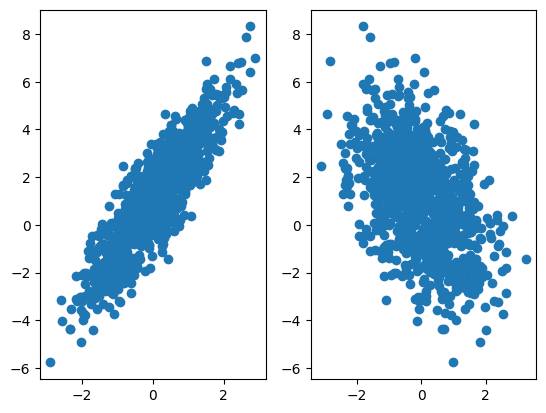

In [20]:
plt.subplot(121)    # 参数说明：1行两列，绘制第一个子图
plt.scatter(features[:, 0], labels)      # 第一个特征和标签的关系
plt.subplot(122)
plt.scatter(features[:, 1], labels)

不难看出，两个特诊和标签都存在一定的线性关系，并且跟特诊的系数绝对值有很大关系。当然，若要增大线性模型的建模难度，可以增加扰动项的数值比例，从而削弱线性关系。

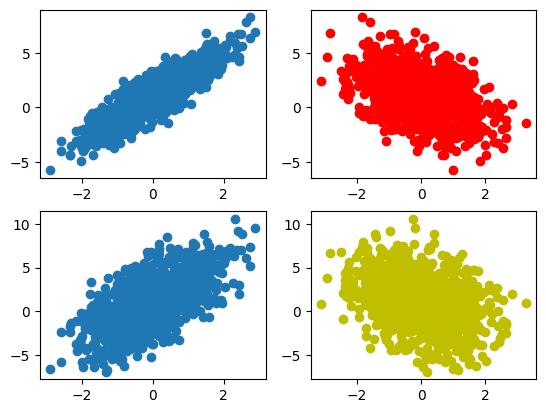

In [25]:
# 设置随机种子
torch.manual_seed(420)

# 修改因变量
labels1 = labels_true + torch.randn(size= labels_true.shape)*2

# 可视化展示

# 扰动项比较小的情况
plt.subplot(221)
plt.scatter(features[:, 0], labels)     # 第一个特征和标签的关系
plt.subplot(222)
plt.plot(features[:, 1], labels, 'ro')  # 第二个特征和标签的关系

# 扰动较大的情况
plt.subplot(223)
plt.scatter(features[:, 0], labels1)        # 第一个特征和标签的关系
plt.subplot(224)
plt.plot(features[:, 1], labels1, 'yo')     # 第二个特征和标签的关系

当然，我们也能生成非线性关系的数据集，此处我们创建满足 $ y = 2x^{2} +1 $ 规律的数据集

torch.Size([1000, 2])
torch.Size([1000, 2])


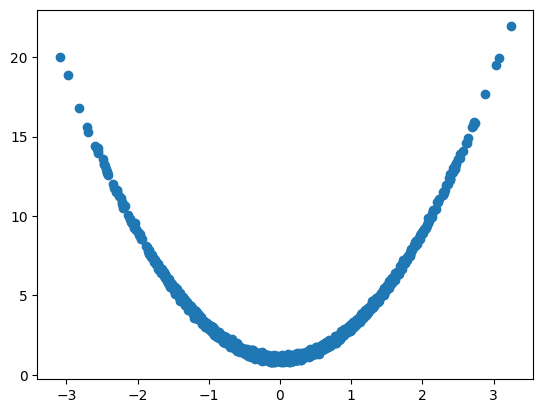

In [29]:
# 设置随机数种子
torch.manual_seed(420)

num_inputs = 2
num_examples = 1000 

# 线性方程系数
w_true = torch.tensor(2.0)
b_true = torch.tensor(1.0)

# 特征和标签取值
features = torch.randn(num_examples, num_inputs)
print(features.shape)
labels_true = torch.pow(features, 2)*w_true + b_true
print(labels_true.shape)
labels = labels_true + torch.randn(size= labels_true.shape)*0.1

# 可视化展示
plt.scatter(features, labels)


2. 创建生成回归类数据的函数

为了方便后续使用，我们将上述过程封装在一个函数内

* 定义创建函数

In [30]:
def tensorGenReg(num_examples = 1000, w = [2, -1, 1], bias = True, delta = 0.01, deg = 1):
    """
    num_examples:创建数据集的数据量
    w:包括截距的特征系数张量
    bias:是否需要截距
    delta:扰动项取值
    deg:方程次数
    return:生成的特征张量和标签张量
    """

    if bias == True:
        num_inputs = len(w) -1